# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; 

### Test for CUDA

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the Data

If you're not familiar with the Cifar-10, you may find it useful to look at: http://www.cs.toronto.edu/~kriz/cifar.html . Or you could search it by yourself. 

If you can't download it online or it takes long time due to the internet, you may use the attachment file provided on the class website

#### TODO: Load the data

In [2]:
# 图象变换和正则化
transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
# 载入数据
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=20,shuffle=True,num_workers=2)
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=20,shuffle=True,num_workers=2)
# 定义类别信息
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


---
## Define the Network Architecture

This time, you'll define a CNN architecture. You may use 
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.


#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation:
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

#### TODO: Define a model with multiple convolutional layers and an output layer for image classification

In [3]:
#Define a CNN model

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class CnnNet(nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()

        self.conv=nn.Sequential(
            nn.Conv2d(3,16,3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,32,3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc=nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )

    def forward(self,x):
        # 将初始化中设置的层连接起来进行前向传播
        feature=self.conv(x)
        output=self.fc(feature.view(-1,64*4*4))
        return output
        
model = CnnNet()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

CnnNet(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. Pay attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer 

In [4]:
import torch.optim as optim

Loss=nn.CrossEntropyLoss() # 采用交叉熵损失函数
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.1) # 随机梯度下降

---
## Train the Network

Remember to look at how the training and validation loss decreases over time and print them.

In [5]:
from torch.autograd import Variable

for epoch in range(50): # 一共循环50次
    running_loss=0.0 # 输出打印需要的参数
    for i,data in enumerate(trainloader):
        inputs,labels=data # 获得trainloader中data的数据和标签
        inputs,labels=Variable(inputs),Variable(labels) # 将数据转换成Variable
        optimizer.zero_grad() # 梯度归零
        
        if train_on_gpu:
            inputs=inputs.type(torch.cuda.FloatTensor)
            labels=labels.type(torch.cuda.FloatTensor).long()

        outputs=model(inputs) # 传进网络
        loss=Loss(outputs,labels) # 损失函数
        loss.backward() # 反向传播
        optimizer.step() # 优化器参数更新
        
        # 打印训练过程
        running_loss+=loss.item()
        if i%1000 ==999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

[1,  1000] loss: 2.302
[1,  2000] loss: 2.256
[2,  1000] loss: 2.022
[2,  2000] loss: 1.898
[3,  1000] loss: 1.730
[3,  2000] loss: 1.650
[4,  1000] loss: 1.570
[4,  2000] loss: 1.509
[5,  1000] loss: 1.437
[5,  2000] loss: 1.409
[6,  1000] loss: 1.340
[6,  2000] loss: 1.293
[7,  1000] loss: 1.243
[7,  2000] loss: 1.226
[8,  1000] loss: 1.164
[8,  2000] loss: 1.147
[9,  1000] loss: 1.087
[9,  2000] loss: 1.080
[10,  1000] loss: 1.022
[10,  2000] loss: 1.022
[11,  1000] loss: 0.971
[11,  2000] loss: 0.963
[12,  1000] loss: 0.933
[12,  2000] loss: 0.925
[13,  1000] loss: 0.871
[13,  2000] loss: 0.888
[14,  1000] loss: 0.838
[14,  2000] loss: 0.846
[15,  1000] loss: 0.806
[15,  2000] loss: 0.806
[16,  1000] loss: 0.777
[16,  2000] loss: 0.776
[17,  1000] loss: 0.732
[17,  2000] loss: 0.740
[18,  1000] loss: 0.708
[18,  2000] loss: 0.714
[19,  1000] loss: 0.659
[19,  2000] loss: 0.689
[20,  1000] loss: 0.636
[20,  2000] loss: 0.649
[21,  1000] loss: 0.614
[21,  2000] loss: 0.625
[22,  1000

---
## Test the Trained Network

Test your trained model on previously unseen data and print the test accuracy of each class and the whole! Try your best to get a better accuracy.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


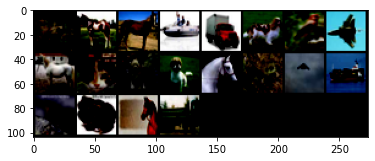

GroundTruth:   frog horse horse  ship truck   dog  bird plane horse   cat   dog   dog horse  frog plane  ship  bird  frog horse truck


In [6]:
import matplotlib.pyplot as plt 

# 读取20张图片
dataiter=iter(testloader) 
images,labels=dataiter.next()
img=torchvision.utils.make_grid(images).numpy()
plt.imshow(np.transpose(img,(1,2,0)))
plt.show()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(20)))

In [7]:
# 用模型预测四张图片
images=Variable(images)
if train_on_gpu:
    images=images.type(torch.cuda.FloatTensor)

outputs=model(images)
_,predicted=torch.max(outputs.data,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(20)))

Predicted:   frog horse horse  ship truck  deer  bird plane horse   cat  frog   dog horse  frog plane  ship  bird  frog   cat truck


In [8]:
# 用模型对整个测试集测试，得出正确率
correct=0
total=0
for data in testloader:
    images,labels=data

    images=Variable(images)
    if train_on_gpu:
        images=images.type(torch.cuda.FloatTensor)
        labels=labels.type(torch.cuda.FloatTensor).long()

    outputs=model(images)
    _,predicted=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct // total))

Accuracy of the network on the 10000 test images: 71 %


In [9]:
# 测试每一类的正确率
class_correct = list(0. for i in range(10)) 
class_total = list(0. for i in range(10))
for data in testloader:    
    images, labels = data

    images=Variable(images)
    if train_on_gpu:
        images=images.type(torch.cuda.FloatTensor)
        labels=labels.type(torch.cuda.FloatTensor).long()

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):  
        label = labels[i] 
        class_correct[label] += c[i]
        class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 84 %
Accuracy of  bird : 62 %
Accuracy of   cat : 53 %
Accuracy of  deer : 61 %
Accuracy of   dog : 61 %
Accuracy of  frog : 78 %
Accuracy of horse : 73 %
Accuracy of  ship : 81 %
Accuracy of truck : 76 %


### Question: What are your model's weaknesses during your experiment and how might they be improved?

可以发现对于动物分类的准确率很低，尤其是猫和鸟，可能是颜色对结果有一定影响，如果不改变结构，增加一个代表颜色的卷积层可能会对提升准确率有一定帮助。在大作业中可以尝试使用VGG或ResNet等模型提高准确率。